# Host analysis and recommendation for prices

   Let us analyze the trends of hosts of Airbnb in Melbourne.

#### Cleaning the data

In [2]:
import pandas as pd
import numpy as np
from collections import Counter

inputDF = pd.read_csv('../data/listings.csv')
inputDF=inputDF[['id','instant_bookable','room_type','host_since','accommodates','bathrooms','bedrooms','beds','amenities','cancellation_policy','review_scores_rating','price']]

# replacing NaN values with 0
inputDF.fillna(0, inplace=True)

#Extracting prices from the table
price = inputDF['price']
prices=[]

#clean the data to make it float
for p in price:
    p=float(p[1:].replace(',',''))
    prices.append(p)

#replace the price column with the new column
inputDF['price']=prices

#exclude the listings with 0 for price,beds,bedrooms,accomodates etc
inputDF = inputDF[inputDF.bathrooms >0]
inputDF = inputDF[inputDF.bedrooms > 0]
inputDF = inputDF[inputDF.beds > 0]
inputDF = inputDF[inputDF.price  > 0]
inputDF = inputDF[inputDF.review_scores_rating  > 0]
inputDF = inputDF[inputDF.accommodates  > 0]

for i,r in inputDF.iterrows():
    inputDF.set_value(i,'year',r['host_since'][:4])
    inputDF.set_value(i,'month',r['host_since'][5:7])
    inputDF.set_value(i,'day',r['host_since'][8:])
inputDF.head()

C:\Users\chait\Anaconda3.7\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (43,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\chait\Anaconda3.7\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\chait\Anaconda3.7\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\chait\Anaconda3.7\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,instant_bookable,room_type,host_since,accommodates,bathrooms,bedrooms,beds,amenities,cancellation_policy,review_scores_rating,price,year,month,day
0,9835,f,Private room,2009-08-21,2,1.0,1.0,2.0,"{Internet,Wifi,""Pets live on this property"",Do...",strict_14_with_grace_period,90.0,60.0,2009,08,21
1,10803,t,Private room,2009-09-16,2,1.0,1.0,1.0,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,H...",strict_14_with_grace_period,88.0,36.0,2009,09,16
2,12936,f,Entire home/apt,2009-10-31,3,1.0,1.0,2.0,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",strict_14_with_grace_period,91.0,159.0,2009,10,31
3,15246,f,Private room,2009-12-03,1,1.5,1.0,1.0,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...",moderate,94.0,50.0,2009,12,03
4,16760,f,Private room,2009-12-22,2,1.0,1.0,1.0,"{Internet,Wifi,Heating,Washer,""Smoke detector""...",moderate,90.0,70.0,2009,12,22


Resampling the year-wise data by each day and plotting it against the number of hosts registered

Text(0,0.5,'number of hosts')

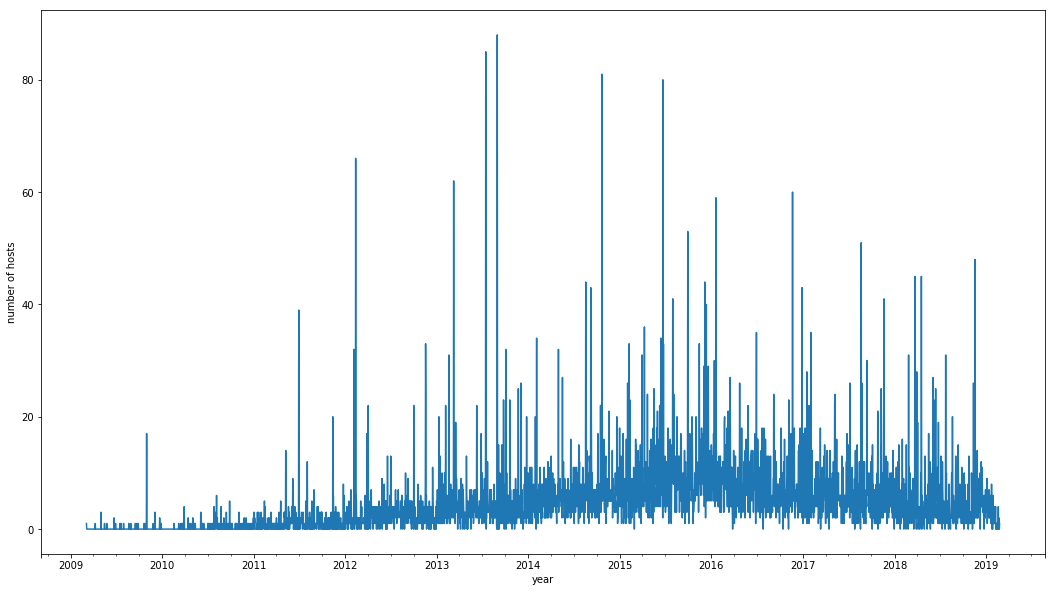

In [3]:
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
join_dates = pd.to_datetime(inputDF['host_since']).value_counts().resample('D').mean().fillna(0)
join_dates.plot()
plt.xlabel('year')
plt.ylabel('number of hosts')

Text(0,0.5,'Number of hosts')

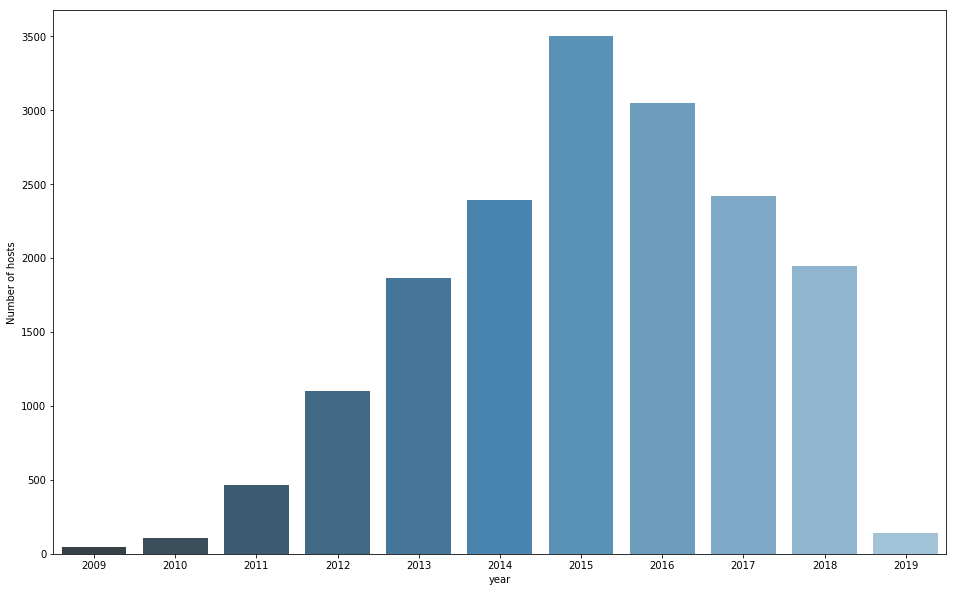

In [4]:
plt.figure(figsize=(16,10))
yearDF=inputDF.groupby(['year']).id.count()
yearDF=yearDF.reset_index()
yearDF=yearDF.rename(columns={'id':'Number of hosts'})
ax = sns.barplot(x='year', y="Number of hosts", data=yearDF,palette="Blues_d")
plt.ylabel('Number of hosts')

From the graph, it can be observed that the year 2015 saw more host registrations compared to other years.

Now, let us plot the graph for all months in each year

C:\Users\chait\Anaconda3.7\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


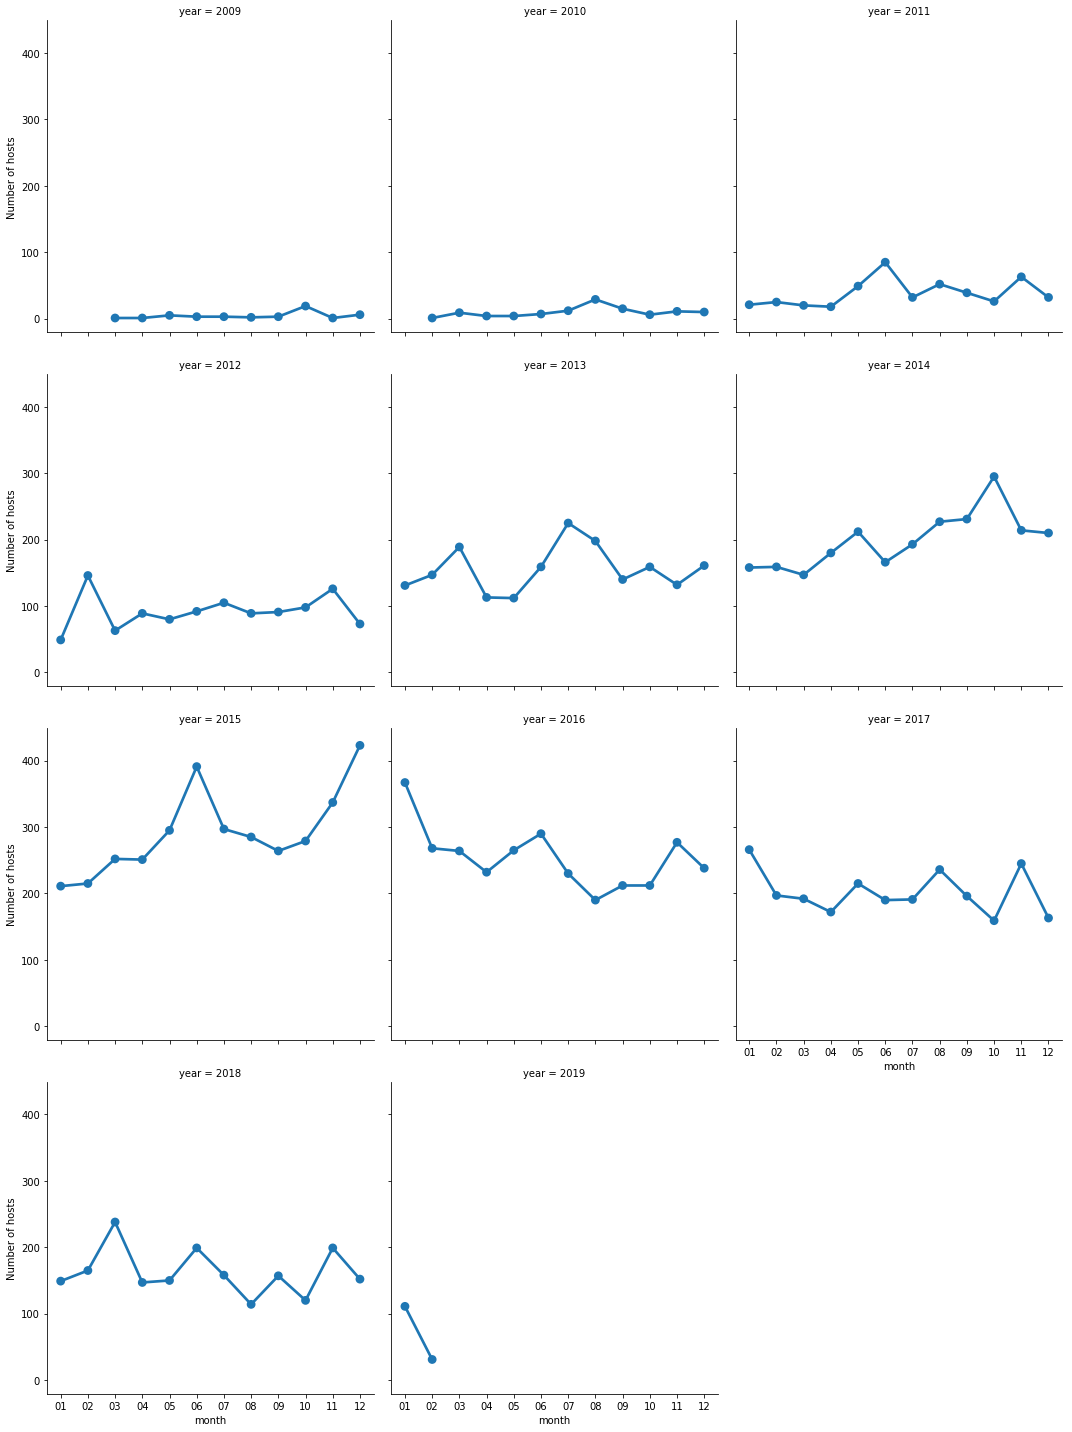

In [5]:
import seaborn as sns

yearMonth=inputDF.groupby(['year','month']).id.count()
yearMonth=yearMonth.reset_index()
yearMonth=yearMonth.sort_values(['year','month'],ascending=[1,1])
yearMonth=yearMonth.rename(columns={"id":"Number of hosts"})
sns.factorplot(data=yearMonth, x="month", y="Number of hosts",col="year",col_wrap=3) 


There is no specific trend followed but by observing, it can be seen that more host registrations occurred during the months of June and November

Plotting the number of hosts register against the day of the week.

Text(0,0.5,'Number of hosts')

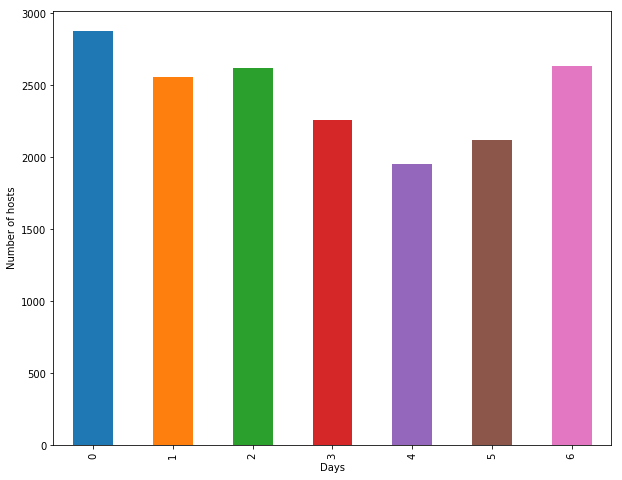

In [6]:
plt.figure(figsize=(10,8))
pd.to_datetime(inputDF['host_since']).dt.dayofweek.value_counts().sort_index().plot(kind='bar')
plt.xlabel("Days")
plt.ylabel("Number of hosts")

After analysing the data, we are trying to develop a recommendation system for the test data bassed on the train data

As the original dataset has many unwanted rows, we considered the columns on which the prices are found to be dependant.<br>
As a part of data cleaning, we removed the rows in which the number of bedrooms, batrooms, beds are 0s and converted the prices column in the dataset into float from string to perform operations

As the data is present in categorical form, we are using the get_dummies() function of pandas to convert the categorical variables into indicator variables. This step is nothing but one-hot encoding of the categorical variables

This will create 4 columns namely flexible, moderate, strict, super_strict_30 as its categories

In [7]:

cancel_policy = pd.get_dummies(inputDF.cancellation_policy).astype(int)
cancel_policy.head()

,flexible,moderate,strict_14_with_grace_period,super_strict_30,super_strict_60
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,1,0,0,0


In the similar way, we converted the other remaining categorical columns instant_booking, room_type into indicator variables

In [8]:
instant_booking = pd.get_dummies(inputDF.instant_bookable, prefix = 'instant_booking').astype(int)
instant_booking.head()

,instant_booking_f,instant_booking_t
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


In [9]:
room_type = pd.get_dummies(inputDF.room_type).astype(int)
room_type.head()

,Entire home/apt,Private room,Shared room
0,0,1,0
1,0,1,0
2,1,0,0
3,0,1,0
4,0,1,0


As all the categorical data is turned into indicator variables (i.e. one hot encoded), the categorical columns in the original dataset can be replaced by the indicator variables.

In [10]:
# drop original columns and replace them with indicator columns

inputDF = inputDF.drop(['cancellation_policy', 'instant_bookable', 'room_type'], axis = 1)
inputDF = pd.concat((inputDF, cancel_policy, instant_booking, room_type), axis = 1)

inputDF.head()

,id,host_since,accommodates,bathrooms,bedrooms,beds,amenities,review_scores_rating,price,year,...,flexible,moderate,strict_14_with_grace_period,super_strict_30,super_strict_60,instant_booking_f,instant_booking_t,Entire home/apt,Private room,Shared room
0,9835,2009-08-21,2,1.0,1.0,2.0,"{Internet,Wifi,""Pets live on this property"",Do...",90.0,60.0,2009,...,0,0,1,0,0,1,0,0,1,0
1,10803,2009-09-16,2,1.0,1.0,1.0,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,H...",88.0,36.0,2009,...,0,0,1,0,0,0,1,0,1,0
2,12936,2009-10-31,3,1.0,1.0,2.0,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",91.0,159.0,2009,...,0,0,1,0,0,1,0,1,0,0
3,15246,2009-12-03,1,1.5,1.0,1.0,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...",94.0,50.0,2009,...,0,1,0,0,0,1,0,0,1,0
4,16760,2009-12-22,2,1.0,1.0,1.0,"{Internet,Wifi,Heating,Washer,""Smoke detector""...",90.0,70.0,2009,...,0,1,0,0,0,1,0,0,1,0


In [11]:
# splitting the amenities list to count the number of amenities
amenities_list = []

for element in inputDF.amenities:
    element = element[1:]
    element = element[:-1]
    x = element.split()
    amenities_list.append(len(x))

inputDF.amenities = amenities_list
inputDF.head()

,id,host_since,accommodates,bathrooms,bedrooms,beds,amenities,review_scores_rating,price,year,...,flexible,moderate,strict_14_with_grace_period,super_strict_30,super_strict_60,instant_booking_f,instant_booking_t,Entire home/apt,Private room,Shared room
0,9835,2009-08-21,2,1.0,1.0,2.0,5,90.0,60.0,2009,...,0,0,1,0,0,1,0,0,1,0
1,10803,2009-09-16,2,1.0,1.0,1.0,29,88.0,36.0,2009,...,0,0,1,0,0,0,1,0,1,0
2,12936,2009-10-31,3,1.0,1.0,2.0,30,91.0,159.0,2009,...,0,0,1,0,0,1,0,1,0,0
3,15246,2009-12-03,1,1.5,1.0,1.0,13,94.0,50.0,2009,...,0,1,0,0,0,1,0,0,1,0
4,16760,2009-12-22,2,1.0,1.0,1.0,6,90.0,70.0,2009,...,0,1,0,0,0,1,0,0,1,0


After our data is cleaned, we used the sklearn's train_test_split() function to seperate our data into training and testing set.

In [12]:
import sklearn.metrics as metrics
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn import metrics
from sklearn import datasets
from sklearn import cross_validation
from sklearn import linear_model
from sklearn import ensemble

split_data= inputDF.drop(['host_since'],axis=1)
train1,test1,train2,test2=cross_validation.train_test_split(split_data,inputDF.price, test_size=0.3,train_size = 0.7,random_state=13)

In [13]:
# Lets analyze if linear regression can predict the prices accurately
# mean of prices
mean = np.mean(inputDF.price)

# standard deviation to compare 
std = np.std(inputDF.price)

print("mean: " + str(mean))
print ("standard deviation: " + str(std))

mean: 149.6472108044627
standard deviation: 262.2516139323643


In [18]:
# linear regression testing
linear_reg = linear_model.LinearRegression()
linear_reg.fit(train1, train2)
linear_reg_error = metrics.mean_absolute_error(test2, linear_reg.predict(test1))
print ("Linear Regression: " + str(linear_reg_error))

Linear Regression: 6.030720324506757e-09


As the dataset is skimmed, it becomes very small and the linear regression that I used to build the recommendation system works on that small dataset, so the recommendation is a bit unstable.